In [1]:
import wrds
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import scipy

In [3]:
db = wrds.Connection()
db.create_pgpass_file()

Loading library list...
Done
Enter your WRDS username [jonkq]:jonkq
Enter your password:········


### 1)

In [4]:
# get rf
rf=db.raw_sql("select mcaldt, tmytm from crsp.tfz_mth_rf where kytreasnox = 2000001 and mcaldt>='1980-01-01' and mcaldt<='2019-12-31'")
rf.to_csv('rf.csv')
# get value-weighted CRSP market return
vwret = db.raw_sql("select date, vwretd from crsp.msi where date>='1980-01-01' and date<='2019-12-31'")
vwret.to_csv('vwret.csv')

In [5]:
rf = pd.read_csv('rf.csv', usecols=['tmytm']).squeeze()
#Compute the monthly simple rate
rf_m = np.exp(rf/12/100)-1

vwret = pd.read_csv('vwret.csv', usecols=['vwretd']).squeeze()

In [11]:
stocks = db.raw_sql("""
                select a.permno, a.date, a.ret, b.exchcd, b.shrcd, a.shrout, a.prc 

                from crsp.msf as a left join crsp.msenames as b 
                
                on a.permno = b.permno and b.namedt <= a.date and a.date<=b.nameendt
                
                where a.date between '1980-01-01' and '2019-12-31'
                and b.exchcd between 1 and 2
                and b.shrcd between 10 and 11""",date_cols=['date'])

stocks.to_csv('stocks.csv')

IndentationError: unexpected indent (<ipython-input-11-d47c6b8bd4e2>, line 3)

In [6]:
stocks = pd.read_csv('C:/Users/jonkq/Documents/EPFL/FIN-405/FIN405_Problem-Sets\8\stocks.csv')

In [7]:
stocks = stocks.iloc[:,1:]

In [8]:
# change table format from long to wide
stocks_df = pd.pivot_table(data=stocks, values='ret', index='date', columns='permno')

In [9]:
s = stocks_df.apply(sum)
s = list(s.isna())
s_i = []
for i in range(len(s)):
    if not s[i]:
        s_i.append(i)
# removing stocks containing NaN values
stocks_df = stocks_df.iloc[:,s_i]

In [10]:
vwret_e = vwret - rf_m
stocks_e = stocks_df - rf_m

### 2)

In [11]:
N = stocks_df.shape[0]
reversal_rets = np.empty(N-1)

for m in range(1, N):
    last_rets = stocks_df.iloc[m-1,:]
    curr_rets = stocks_df.iloc[m,:]
    last_rets_ord = list(np.argsort(last_rets))
    loosers_idx = last_rets_ord[:10]
    winners_idx = last_rets_ord[-10:]
    loosers_ret = np.mean(curr_rets.iloc[loosers_idx])
    winners_ret = np.mean(curr_rets.iloc[winners_idx])
    reversal_ret = loosers_ret - winners_ret
    reversal_rets[m-1] = reversal_ret

### 3)

In [12]:
rev_avg = np.mean(reversal_rets)
rev_std = np.std(reversal_rets)
rev_sr = (rev_avg - np.mean(rf_m))/rev_std
print('Reversal strategy monthly return statistics\n\nAverage: {:.3}%\nStd: {:.3}%\nSharpe ratio: {:.3}'.format(100*rev_avg, 100*rev_std, rev_sr))

Reversal strategy monthly return statistics

Average: 1.35%
Std: 7.58%
Sharpe ratio: 0.134


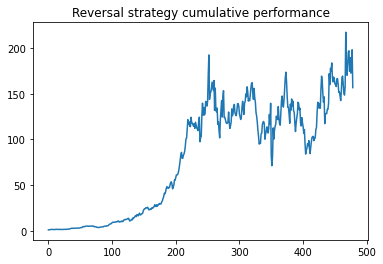

In [13]:
rev_cum = np.cumprod(1+reversal_rets)
plt.plot(rev_cum)
plt.title('Reversal strategy cumulative performance');

### 4)

In [14]:
x = np.array(vwret[1:]).reshape(-1,1)
y = reversal_rets.reshape(-1,1)
lm1 = LinearRegression().fit(x, y)

In [15]:
rev_beta = lm1.coef_.item()
rev_alpha = lm1.intercept_.item()
lm1_res = lm1.predict(x) - y
lm1_ssr = np.square(lm1_res).sum()
X = np.concatenate((np.ones(N-1).reshape(-1,1),x), 1)
s_hat = lm1_ssr/(N-1-2)
var_coefs = np.linalg.inv(X.T@X) * s_hat
se_alpha = var_coefs[0,0]**(1/2)
dfs = N-1-1-2
rev_alpha_t_stat = rev_alpha/se_alpha
rev_alpha_p_val = 1-scipy.stats.t(dfs).cdf(rev_alpha_t_stat)

In [16]:
print('Reversal strategy vs CAPM\n\nAlpha: {:.3} (p-value: {:.3})\nBeta: {:.3}'
     .format(rev_alpha, rev_alpha_p_val, rev_beta))

Reversal strategy vs CAPM

Alpha: 0.0116 (p-value: 0.000553)
Beta: 0.195


This regression clearly shows that the reversal strategy is not consistent with CAPM since this strategy produces a strongly significant monthly alpha of 1.16%.

### 5)

In [17]:
N = stocks_df.shape[0]
momentum_rets = []

for m in range(12, N):
    last_rets = np.array(stocks_df.iloc[(m-12):(m-1),:])
    curr_rets = np.array(stocks_df.iloc[m,:])
    last_rets_m = last_rets.mean(0)
    last_rets_ord = list(np.argsort(last_rets_m))
    loosers_idx = last_rets_ord[:10]
    winners_idx = last_rets_ord[-10:]
    loosers_ret = np.mean(curr_rets[loosers_idx])
    winners_ret = np.mean(curr_rets[winners_idx])
    momentum_ret = winners_ret - loosers_ret
    momentum_rets.append(momentum_ret)
momentum_rets = np.array(momentum_rets)

### 6)

In [18]:
rev_avg = np.mean(momentum_rets)
rev_std = np.std(momentum_rets)
rev_sr = (rev_avg - np.mean(rf_m))/rev_std
print('Momentum strategy monthly return statistics\n\nAverage: {:.3}%\nStd: {:.3}%\nSharpe ratio: {:.3}'.format(100*rev_avg, 100*rev_std, rev_sr))

Momentum strategy monthly return statistics

Average: 0.148%
Std: 9.62%
Sharpe ratio: -0.0198


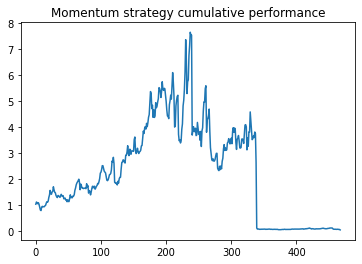

In [19]:
mom_cum = np.cumprod(1+momentum_rets)
plt.plot(mom_cum)
plt.title('Momentum strategy cumulative performance');

### 7)

In [20]:
x1 = np.array(vwret[12:]).reshape(-1,1)
x2 = reversal_rets[11:].reshape(-1,1)
x = np.concatenate((x1,x2),1)
y = momentum_rets.reshape(-1,1)
lm2 = LinearRegression().fit(x, y)

In [21]:
mom_beta_mkt = lm2.coef_[0][0].item()
mom_beta_rev = lm2.coef_[0][1].item()
mom_alpha = lm2.intercept_.item()
lm2_res = lm2.predict(x) - y
lm2_ssr = np.square(lm2_res).sum()
X = np.concatenate((np.ones(N-12).reshape(-1,1),x), 1)
s_hat = lm2_ssr/(N-12-2)
var_coefs = np.linalg.inv(X.T@X) * s_hat
se_alpha = var_coefs[0,0]**(1/2)
dfs = N-12-1-2
mom_alpha_t_stat = mom_alpha/se_alpha
mom_alpha_p_val = 1-scipy.stats.t(dfs).cdf(mom_alpha_t_stat)
mom_beta_mkt_pval = 1-scipy.stats.t(dfs).cdf(mom_beta_mkt/(var_coefs[1,1]**.5))
mom_beta_rev_pval = 1-scipy.stats.t(dfs).cdf(mom_beta_rev/(var_coefs[2,2]**.5))

In [22]:
print('Momentum strategy vs CAPM and Reversal\n\nAlpha: {:.3} (p-value: {:.3})\nBeta to market: {:.3} (p-value: {:.3})\nBeta to reversal: {:.3} (p-value: {:.3})'
     .format(mom_alpha, mom_alpha_p_val, mom_beta_mkt, mom_beta_mkt_pval, mom_beta_rev, mom_beta_rev_pval))

Momentum strategy vs CAPM and Reversal

Alpha: 0.00141 (p-value: 0.379)
Beta to market: -0.192 (p-value: 0.969)
Beta to reversal: 0.147 (p-value: 0.00633)


The momentum strategy's alpha of 0.141% is not at all significant which implies that CAPM (or 2 factor model?) holds for this strategy.

### 8)

In [52]:
# Find the slope portfolio between Momentum, Reversal and Market portfolios
pfs = np.concatenate((y,x2,x1),1)
mu = pfs.mean(0)
sig = np.cov(pfs, rowvar=False)
sig_inv = np.linalg.inv(sig)
B = sig_inv.sum(0) @ mu

w = (sig_inv @ mu)/B

In [61]:
print('The optimal portfolio composition is:\nMomentum: {:.3}%\nReversal: {:.3}%\nMarket: {:.3}%\nTotal: {}%'
      .format(100*w[0], 100*w[1], 100*w[2], 100*w.sum()))

The optimal portfolio composition is:
Momentum: 2.3%
Reversal: 28.2%
Market: 69.5%
Total: 100.0%


In [72]:
pf_mu = w.dot(mu)
pf_var = w.dot(sig).dot(w)
pf_SR = (pf_mu-rf_m.mean())/np.sqrt(pf_var)

In [75]:
print('The maximum Sharpe ratio that can be obtained with these three portfolios is {:.3}.'.format(pf_SR))

The maximum Sharpe ratio that can be obtained with these three portfolios is 0.177.
